# Imports

In [1]:
from acquire import acquire_data
from wrangle import wrangle_data

import numpy as np
import pandas as pd

import graph
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import linregress, ttest_1samp

from math import sqrt

# Aqcuisition

In [2]:
df = acquire_data()

csv has been previously generated.
Data Acquired


In [3]:
df.head()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,fips,FIPS,Name,State
0,0,3.0,2.0,1458.0,136104.0,2319.90,6037.0,6037,Los Angeles,CA
1,1,2.0,1.0,1421.0,35606.0,543.69,6037.0,6037,Los Angeles,CA
2,2,3.0,2.0,1650.0,614000.0,7673.19,6037.0,6037,Los Angeles,CA
3,3,2.0,1.0,693.0,274237.0,3267.47,6037.0,6037,Los Angeles,CA
4,4,0.0,0.0,1378.0,168828.0,2135.39,6037.0,6037,Los Angeles,CA


In [4]:
df.dtypes

Unnamed: 0                        int64
bedroomcnt                      float64
bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
taxvaluedollarcnt               float64
taxamount                       float64
fips                            float64
FIPS                              int64
Name                             object
State                            object
dtype: object

In [5]:
df.describe()

,Unnamed: 0,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,taxamount,fips,FIPS
count,15036.000000,15036.000000,15036.000000,15012.000000,1.503600e+04,15035.000000,15036.000000,15036.000000
mean,7517.500000,3.307595,2.322426,1942.043165,5.434477e+05,6618.896851,6049.395318,6049.395318
std,4340.663659,0.951095,1.025202,1001.672378,7.354153e+05,8513.788079,21.237001,21.237001
min,0.000000,0.000000,0.000000,300.000000,1.050400e+04,51.260000,6037.000000,6037.000000
25%,3758.750000,3.000000,2.000000,1274.750000,1.986335e+05,2707.960000,6037.000000,6037.000000
50%,7517.500000,3.000000,2.000000,1679.000000,3.851740e+05,4775.900000,6037.000000,6037.000000
75%,11276.250000,4.000000,3.000000,2346.000000,6.452412e+05,7683.940000,6059.000000,6059.000000
max,15035.000000,12.000000,11.000000,15450.000000,2.385837e+07,276797.830000,6111.000000,6111.000000


In [6]:
print(f'Total number of rows: {len(df)}')

Total number of rows: 15036


# Preparation

In [7]:
seed = 115
train_size = .8

train, test = wrangle_data(df, seed, train_size)

Data Prepared and Split


In [8]:
train.head()

,bedroom_count,bathroom_count,total_sqft,property_value,tax_amount,county,state
13032,2.0,2.0,1194.0,371363.0,4111.36,Orange,CA
1502,3.0,2.0,1794.0,705598.0,8693.67,Los Angeles,CA
4736,3.0,2.0,1215.0,185287.0,2437.92,Los Angeles,CA
11558,3.0,2.5,1709.0,653422.0,7024.88,Orange,CA
6444,4.0,6.0,5862.0,1279726.0,15645.06,Los Angeles,CA


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11991 entries, 13032 to 6949
Data columns (total 7 columns):
bedroom_count     11991 non-null float64
bathroom_count    11991 non-null float64
total_sqft        11991 non-null float64
property_value    11991 non-null float64
tax_amount        11991 non-null float64
county            11991 non-null object
state             11991 non-null object
dtypes: float64(5), object(2)
memory usage: 749.4+ KB


# Exploration

## Exploration Goals

* Create a hypothesis
* Calculate the county tax rates and then create graphs to show
* Run statistical tests
* Create graphs that highlights the effect these three features have on the price of a home
* Get an idea of underlying patterns in the data and describe take-aways

## Hypothesis

$H_0$: The three selected features have no linear correlation with the property value 

$H_1$: The three selected values do have a linear correlation with property value

My hypothesis is that there is a heavy correlation, not only between each feature and the property value but also between each feature. 

## County Tax Rates

### Create a Tax Rate Column

In [10]:
df['tax_rate'] = df.tax_amount / df.property_value

In [11]:
df.head()

,bedroom_count,bathroom_count,total_sqft,property_value,tax_amount,county,state,tax_rate
0,3.0,2.0,1458.0,136104.0,2319.90,Los Angeles,CA,0.017045
1,2.0,1.0,1421.0,35606.0,543.69,Los Angeles,CA,0.015270
2,3.0,2.0,1650.0,614000.0,7673.19,Los Angeles,CA,0.012497
3,2.0,1.0,693.0,274237.0,3267.47,Los Angeles,CA,0.011915
5,3.0,2.0,1108.0,486866.0,5990.50,Los Angeles,CA,0.012304


In [12]:
df.groupby('county')['tax_rate'].mean().round(3)

county
Los Angeles    0.014
Orange         0.012
Ventura        0.012
Name: tax_rate, dtype: float64

In [13]:
tax_los_angeles = df[df.county == 'Los Angeles'][['county', 'tax_rate']]
tax_orange = df[df.county == 'Orange'][['county', 'tax_rate']]
tax_ventura = df[df.county == 'Ventura'][['county', 'tax_rate']]

### Graph the Distribution of Taxes by County

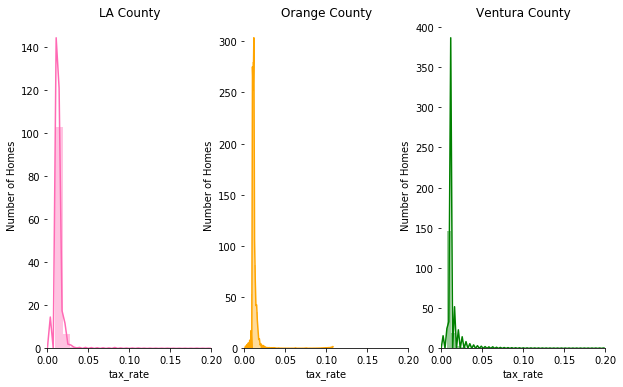

In [14]:
graph.plot_county_taxes(tax_los_angeles, tax_orange, tax_ventura)

## Statistical Testing

### T-test

In [15]:
alpha = 0.05

la = df[df.county == 'Los Angeles'][['property_value']]
orange = df[df.county == 'Orange'][['property_value']]
ventura = df[df.county == 'Ventura'][['property_value']]

In [16]:
# T-test for LA
tstat, p = ttest_1samp(la.property_value, train.property_value.mean())
print(p)

0.0004266993499083111


In [17]:
# T-test for Orange
tstat, p = ttest_1samp(orange.property_value, train.property_value.mean())
print(p)

2.825719490265209e-14


In [18]:
# T-test for Ventura
tstat, p = ttest_1samp(ventura.property_value, train.property_value.mean())
print(p)

1.175821519650124e-05


## Graph the Features

> Graphing the features here to get a look at the relationships in the data

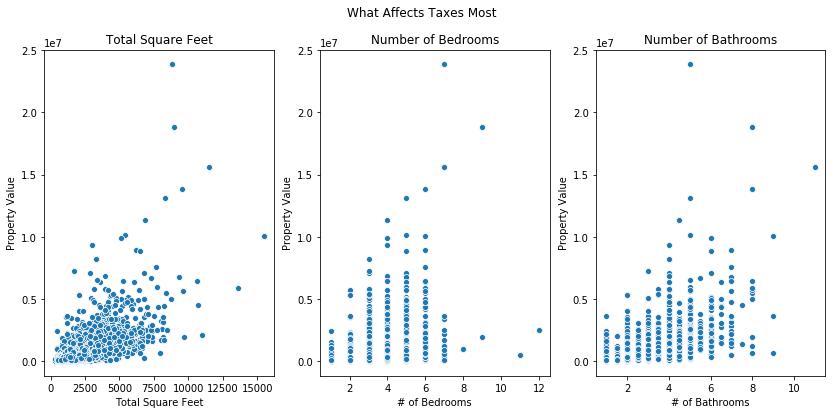

In [19]:
graph.plot_features(train)

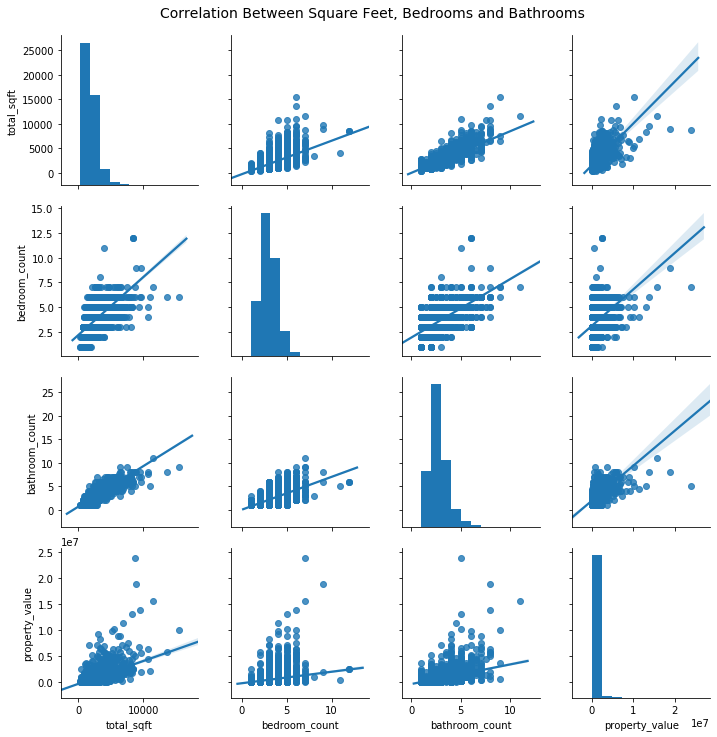

<Figure size 1152x1152 with 0 Axes>

In [20]:
graph.graph_pairplot(train)

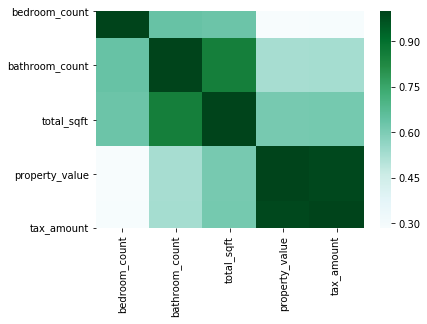

In [21]:
graph.graph_corr(train)

# Modeling

## Create a Dataframe to Hold Actual and Predicted Values

In [22]:
predictions = pd.DataFrame(
    {'actual': train.property_value})

## Create Basic Models (Measures a Single Feature)

In [23]:
y = train.property_value

In [24]:
# Model Using the Total Square Feet to Predict Tax Amount

x1 = train[['total_sqft']]

lm_sqft = LinearRegression().fit(x1, y)

In [25]:
# Model Using the Number of Bedrooms to Predict Tax Amount

x2 = train[['bedroom_count']]

lm_bedroom = LinearRegression().fit(x2, y)

In [26]:
# Model Using the Number of Bathrooms to Predict Tax Amount

x3 = train[['bathroom_count']]

lm_bathroom = LinearRegression().fit(x3, y)

In [27]:
# Model Using All 3 Features Together

x4 = train[['total_sqft', 'bedroom_count', 'bathroom_count']]

lm_sqft_bed_bath = LinearRegression().fit(x4, y)

## Use the  Models to Create Predictions

In [28]:
predictions['baseline'] = train.property_value.mean()
predictions['lm_sqft'] = lm_sqft.predict(x1)
predictions['lm_bedroom'] = lm_bedroom.predict(x2)
predictions['lm_bathroom'] = lm_bathroom.predict(x3)
predictions['lm_sqft_bed_bath'] = lm_sqft_bed_bath.predict(x4)

In [29]:
predictions.head()

,actual,baseline,lm_sqft,lm_bedroom,lm_bathroom,lm_sqft_bed_bath
13032,371363.0,543975.056876,2.090748e+05,252060.449869,4.162489e+05,3.548299e+05
1502,705598.0,543975.056876,4.724507e+05,471848.723925,4.162489e+05,4.938469e+05
4736,185287.0,543975.056876,2.182930e+05,471848.723925,4.162489e+05,2.210103e+05
11558,653422.0,543975.056876,4.351391e+05,471848.723925,6.038487e+05,4.839165e+05
6444,1279726.0,543975.056876,2.258140e+06,691636.997982,1.917047e+06,2.508042e+06


# Evaluation

## Comparison Graphing

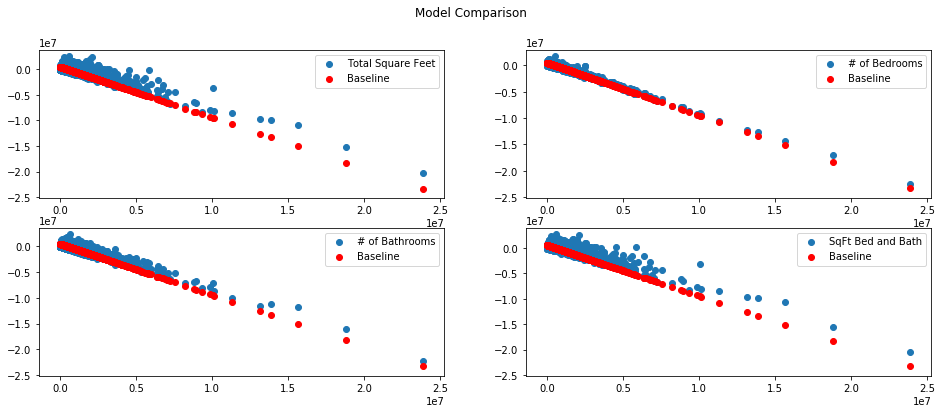

In [30]:
graph.graph_train_models(predictions)

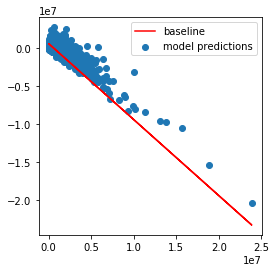

In [41]:
plt.figure(figsize=(4,4))
plt.scatter(y=predictions.lm_sqft_bed_bath - predictions.actual, x=predictions.actual, label='model predictions')
plt.plot(predictions.actual, predictions.baseline - predictions.actual, color='red', label='baseline')
plt.legend()

## Use RMSE to Compare Models

In [32]:
rmse_results = {
'baseline_model' : sqrt(mse(predictions.actual, predictions.baseline)),   
'sqft_model' : sqrt(mse(predictions.actual, predictions.lm_sqft)),
'bedroom_model' : sqrt(mse(predictions.actual, predictions.lm_bedroom)),
'bathroom_model' : sqrt(mse(predictions.actual, predictions.lm_bathroom)),
'sqft_bedroom_bathroom_model' : sqrt(mse(predictions.actual, predictions.lm_sqft_bed_bath))
}

In [33]:
for key in rmse_results:
    print(f'{key}: {rmse_results[key]}')

baseline_model: 727632.7272011177
sqft_model: 575449.9930252726
bedroom_model: 697667.1918034669
bathroom_model: 618105.544202186
sqft_bedroom_bathroom_model: 566416.9632290684


## Evaluating the Best Model to Test for Overfitting

In [34]:
X_test = test[['total_sqft', 'bedroom_count', 'bathroom_count']]
y = test.property_value

In [35]:
test_predictions = pd.DataFrame(
    {'actual': test.property_value})

In [36]:
test_predictions.head()

,actual
4381,443629.0
11882,294236.0
10796,440197.0
1890,179768.0
7772,704537.0


In [37]:
test_predictions['baseline'] = test.property_value.mean()
test_predictions['lm_sqft_bed_bath'] = lm_sqft_bed_bath.predict(X_test)

In [38]:
test_predictions.head()

,actual,baseline,lm_sqft_bed_bath
4381,443629.0,532636.370247,279448.675769
11882,294236.0,532636.370247,584729.827421
10796,440197.0,532636.370247,516465.496479
1890,179768.0,532636.370247,437771.693244
7772,704537.0,532636.370247,585263.671761


In [39]:
rmse_model = sqrt(mse(test_predictions.actual, test_predictions.lm_sqft_bed_bath))
rmse_baseline = sqrt(mse(test_predictions.actual, test_predictions.baseline))

In [40]:
print(rmse_model, rmse_baseline)

604272.6877648521 743938.074163598


In [42]:
print(rmse_baseline - rmse_model)

139665.38639874593


## Result

__Model using a combination of all three features performed the best__. 
Additionally, model beats baseline indicating model is significant.

> The model using all three features (total square feet, # of bedrooms and # of bathrooms) outperformed the other models using individual features. We'll be using the winning model, which I'll put into a seperate model.py.